In [1]:
import numpy
from scipy.stats import truncnorm, norm, binom, ks_2samp, ttest_ind
from scipy.optimize import least_squares, minimize, minimize_scalar
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import pdb                       # For debugging
import os                        # For filesystem management
from tqdm import tqdm            # Gives loading bar while running
from multiprocessing import Pool # For parallel execution

In [2]:
# The following directory tells the code where to store the generated configurations
# Change this !
base_directory = "/Users/benkitching-morley/"

In order to perform multilevel, we need a way to label the subregions of the lattice. region_maker is a generalized function that takes the sidelength of the lattice, L, and a tuple of the splitting, s, as inputs. Each element of s is the number of sublattices in a given dimension - the number of dimensions are inferred by the lenghth of s. The boundary layers are labelled by 0, while the subregions are numbered 1, 2, ... . For example, region_maker(8, (2, )) returns [0, 1, 1, 1, 0, 2, 2, 2].

In [3]:
def region_maker(L, s):
  """
    This function will return a function, which can be used to see which region
    of the lattice a given point is in.

    L : int, size of the lattice (Assumed to be the same size in all directions currently.)
    s : (n, ) tuple of ints, describing how the lattice is to be broken
      down in the directions (x1, ..., xn). For simlicity I have programmed this
      to only accept ints that divide L exactly
  """
  dim = len(s)

  shape = (L, ) * dim
  regions = numpy.zeros(shape)

  for i in s:
    assert type(i) == int
    assert i >= 1
    assert L % i == 0, "The lattice size must divide exactly into the number of subregions"

  # Size of sublattices in each direction
  size = L // numpy.array(s)

  # Use a recursive function to label the regions uniquely
  def label(x, n):
    if n == 0:
      return 0

    # Add 1 to distiguish regions from the boundary
    if n == dim:
      return label(x, n - 1) * s[n - 1] + x[n - 1] // size[n - 1] + 1

    else:
      return label(x, n - 1) * s[n - 1] + x[n - 1] // size[n - 1]

  if numpy.product(numpy.array(s)) == 1:
    def which_region(x, x2=None, x3=None):
      return 1

  else:
    def which_region(x):
      """
        This function returns the region of the lattice a coordinate is in

        x : (d, ) list of ints, representing the coordinate on the lattice. Can
          also be a single int, in the case that the other coordinates are included

        RETURNS :
        ---------
        region : int, label of region. Note that region 0 is reserved for the boundary.
      """
      for i in x:
        assert type(i) == int
        assert i < L and i >= 0
      
      # First check if the coordinate is on the boundary. If so return 0.
      for i in range(dim):
        if s[i] > 1:
          if x[i] % (L // s[i]) == 0:
             return 0

      # If the point isn't on the boundary then use the recursive function
      # label defined previously
      return label(x, dim)
  
  # Now use the function which_region to caclulate the region of each point
  regions = numpy.zeros(shape)

  indices = numpy.indices(shape)

  def cycle(regions, stored, dim):
    if dim == 1:
      for i in range(L):
        new_stored = stored + [i]
        regions[i] = which_region(new_stored)
      
      return regions

    else:
      for i in range(L):
        new_stored = stored + [i]
        regions[i] = cycle(regions[i], new_stored, dim - 1)
      
      return regions

  regions = cycle(regions, [], dim)

  return regions


Let's check the region maker gives the expected output when splitting a 2D lattice into 4 quadrants, e.g. s = (2, 2)

In [4]:
assert numpy.array_equal(region_maker(8, (2, 2)),
                          numpy.array([[0, 0, 0, 0, 0, 0, 0, 0],
                                       [0, 1, 1, 1, 0, 2, 2, 2],
                                       [0, 1, 1, 1, 0, 2, 2, 2],
                                       [0, 1, 1, 1, 0, 2, 2, 2],
                                       [0, 0, 0, 0, 0, 0, 0, 0],
                                       [0, 3, 3, 3, 0, 4, 4, 4],
                                       [0, 3, 3, 3, 0, 4, 4, 4],
                                       [0, 3, 3, 3, 0, 4, 4, 4]]))

In order to visualize what is coming it will be important to plot the spins nicely. The spin array elements will take values of +1 for spin up, and -1 for spin down. This function takes a matplotlib axis as input, as well as an array of spins, for the purpose of making movies later.

In [5]:
def plot_spins(spins, ax):
  L = spins.shape[0]

  # create discrete colormap
  cmap = colors.ListedColormap(['red', 'blue'])
  bounds = [-2, 0, 2]
  norm = colors.BoundaryNorm(bounds, cmap.N)

  ax.imshow(spins, cmap=cmap, norm=norm)

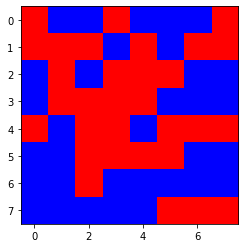

In [6]:
spin_test = numpy.random.randint(2, size=(8, 8)) * 2 - 1

fig, ax = plt.subplots()  # Create an empty figure

plot_spins(spin_test, ax)

plt.show()  # Display the figure

For the purpose of parrallelisation, the following function constructs a chessboard pattern over a lattice. This is only possible on lattices with even side lengths, because of periodic boundary conditions. This function is written for 2D though higher dimensional patterns would be possible.

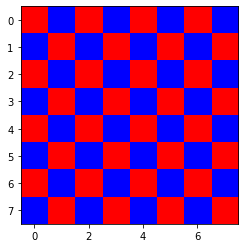

In [7]:
def chessboard_2D(L):
  board = numpy.zeros((L, L), dtype=int)
  for i in range(L):
    for j in range(L):
      board[i, j] = (i + j) % 2
  return board

fig, ax = plt.subplots()
plot_spins(chessboard_2D(8) * 2 - 1, ax)
plt.show()

In the Ising model the energy is given by
$H = -J \sum_{i, j n.n.}s_is_j - B\sum_i s_i$, where n.n. stands for nearest neighbours. It behooves us therefore to have an easy way to calculate the sum of the nearest neighbours to a point. This is done by the following function

In [8]:
def neighbour_total(spin_array):
  """
    This function takes an array of spins, and returns at each position in
    the lattice, the total of the neighbouring spins to that lattice position.

    INPUTS :
    --------
    spin_array: numpy array object with entries of either 1 or (-1) as in
                initialise_problem function

    OUTPUTS :
    ---------
    total_neighbour_spin: an array of the same shape as the spin_array, but
                          at each lattice site is the total of the neighbouring
                          spins.
  """
  total_neighbour_spin = numpy.zeros(spin_array.shape)

  for dim in range(len(spin_array.shape)):
    total_neighbour_spin += numpy.roll(spin_array, 1, axis=dim)
    total_neighbour_spin += numpy.roll(spin_array, -1, axis=dim)

  return total_neighbour_spin

We are therefore ready to now construct the object which will underlie our Ising model simulations. We will use a class object for flexibility

In [9]:
class lattice(object):
  def __init__(self, L, splitting, beta=1, spins=None):
    """
        INPUTS :
        --------
        L : int, sidelength of lattice
        splitting : tuple of ints, the number of sublattices in each dimension
        beta : the inverse temperature, float
        spins : A given starting configuration of spins. If None then the starting configuration of spins will
            be generated randomly
    """
    assert L % 2 == 0, "L must be a mulitple of 2 for the chessboard method to be valid"

    if spins is None:
      spins = numpy.random.randint(0, 2, size=(L, L)) * 2 - 1
    else:
      self.spins = spins

    self.spins = numpy.array(spins, dtype=numpy.int8) # For reduced memory / harddrive usage
    self.chessboard = chessboard_2D(L)
    self.regions = region_maker(L, splitting)
    self.beta = beta

    # To be clear this is the total energy associated with all interactions at
    # a point - to get the correct total energy density this value should be
    # halved, since interactions involve two sites
    self.energies = - self.spins * neighbour_total(self.spins)
    self.L = L

  def step(self):
    # Flip the white squares first (of the "chessboard")
    delta_E = - self.energies * 2  # The amount the energy will change if the spin flips
    
    # Using the metropolis algorithm
    jump_condition = numpy.exp(- self.beta * delta_E) > numpy.random.rand(self.L, self.L)

    # Flip a site if
    # 1. It passes the Metropolis-Hastings flip condition
    # 2. The site isn't on the boundary
    # 3. It is one of the squares on the chessboard being flipped
    to_flip = numpy.logical_and(jump_condition,
                    numpy.logical_and(self.regions, self.chessboard))

    self.spins = numpy.where(to_flip, -self.spins, self.spins)
    
    # Recalculate all site energies - not just the sites that have just been flipped
    self.energies = - self.spins * neighbour_total(self.spins)

    # Now flip the black squares
    delta_E = - self.energies * 2
    jump_condition = numpy.exp(- self.beta * delta_E) > numpy.random.rand(self.L, self.L)

    to_flip = numpy.logical_and(jump_condition,
                    numpy.logical_and(self.regions, numpy.logical_not(self.chessboard)))

    self.spins = numpy.where(to_flip, -self.spins, self.spins)
    self.energies = - self.spins * neighbour_total(self.spins)


The following function generates single level Ising states - by which I mean there is no splitting of the lattice into subregions

In [10]:
def generate_states_1_1(L, beta, N, step, initial, rerun=False, initial_spins=None):
  """
    INPUTS :
    --------
    L : int, sidelength of lattice
    beta : the inverse temperature, float
    N : Number of configurations to save in the esemble, int
    step : Number of update steps between configs, int
    initial : Thermalization steps - number of MH steps done before the first config is measured
    rerun : Bool, if True then rerun the generation even if a saved file with this ensemble is found
    initial_spins : A given starting configuration of spins. If None then the starting configuration of spins will
        be generated randomly
        
    OUTPUTS :
    ---------
    data : (N, L, L) numpy array of ints representing N spin configurations
  """
  # Conventions for saving file
  directory = f"{base_directory}ising/L{L}/b{beta:.10f}/"
  filename = f"L{L}_b{beta:.10f}_N{N}_init{initial}_step{step}_spins_1_1.npy"

  def run():
    print(f"Generating states for : L = {L}, N = {N}, beta = {beta:.10f}, splitting = (1, 1)")

    data = numpy.zeros((N, L, L), dtype=numpy.int8)
    
    x = lattice(L, (1, 1), beta=beta, spins=initial_spins)

    for j in range(initial):
      x.step()

    count = 0
    for i in tqdm(range((N - 1) * step + 1)):
      if(i % step == 0):
        data[count] = x.spins
        count += 1

      x.step()
    
    # If the directory for data to be saved into doesn't exist then make it.
    # This method is used many times in this code
    if not os.path.isdir(directory):
      os.makedirs(directory)

    numpy.save(f"{directory}{filename}", data)

    return data

  if not rerun:
    # Check if the file exists
    files = os.popen(f'ls {directory}')
    files = [x[:-1] for x in files]  # Remove the '\n' charachter from filenames
    if not filename in files:
      data = run()
    
    else:
      data = numpy.load(f"{directory}{filename}")

  else:  # Always run if rerun is True
    data = run()
  
  return data

To generate ensembles with a split lattice the technique is very similar except an underlying single-level ensemble is required to get the boundary configurations

In [11]:
def generate_states_splitting(L, beta, N, M, Mstep, splitting, source_file_N, source_file_init, Nstep=1, source_file_step=True, rerun=False):
  """
    INPUTS :
    --------
    L : size length, int
    beta : inverse temperature, float
    N : Number of boundary configurations
    M : Number of sublattice configs per boundary
    Mstep : Number of update steps between sublattice configs
    splitting : (2, ) tuple of ints giving the number of lattice splittings in each direction
    source_file_N : Number of configs in base single level simulation data, int
    Nstep : Number of configs from source between boundary configs,  e.g. if
      the source file keeps every 10th lattice state and Nstep is 2, then every
      other saved config is used as a starting point for the sublattice simulation,
      e.g. every 20th iteraction of the source algorithm. int
    source_file : the name of the file containing the starting boundary configurations
    source_file_step : number of updates per config used to generate single level data, 
        if true set to the same as Mstep
    
    OUTPUTS :
    ---------
    data : (N, M, L, L) numpy array of {-1, 1} representing the spin configurations
  """
  i, j = splitting[0], splitting[1]

  if source_file_step:
    source_file_step = Mstep

  directory = f"{base_directory}ising/L{L}/b{beta:.10f}/"
  filename = f"L{L}_b{beta:.10f}_N{N}_M{M}_Mstep{Mstep}_sourceN{source_file_N}_sourceinit{source_file_init}_sourcestep{source_file_step}_Nstep{Nstep}_spins_{i}_{j}.npy"

  def run():
    data = numpy.zeros((N, M, L, L), dtype=numpy.int8)
    
    # File template of same form as in the previous function
    source_file = f"L{L}_b{beta:.10f}_N{source_file_N}_init{source_file_init}_step{source_file_step}_spins_1_1.npy"

    # Check if the source file exists
    files = os.popen(f'ls {directory}')
    files = [x[:-1] for x in files]
    
    if not source_file in files:
      print("No source configuration files - generating these first")
      generate_states_1_1(L, beta, source_file_N, source_file_step, source_file_init, rerun=False)

    # Load in N configs from source file in steps of Nstep
    source_data = numpy.load(f"{directory}{source_file}")[0:Nstep * N:Nstep]

    print(f"Generating states for : L = {L}, N = {N}, M = {M}, beta = {beta:.10f}, splitting = ({i}, {j})")

    for k in tqdm(range(N)):
      # Use the spin configurations from the single level data as starting points
      x = lattice(L, splitting, beta=beta, spins=source_data[k])
      
      for l in tqdm(range((M - 1) * Mstep + 1)):
        if l % Mstep == 0:
          data[k, l // Mstep] = x.spins

        x.step()
  
    numpy.save(f"{directory}{filename}", data)

    return data

  if not rerun:
    # Check if the file exists
    files = os.popen(f'ls {directory}')
    files = [x[:-1] for x in files]
    
    if not filename in files:
      data = run()
    
    else:
      data = numpy.load(f"{directory}{filename}")

  else:
    data = run()

  return data


Let's just check that things are working as expected. I've made a movie that will iterate through some of this multilevel data

In [12]:
%matplotlib inline

from scipy import optimize
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import matplotlib
from matplotlib import animation, rc
from matplotlib.animation import FuncAnimation
from IPython.display import HTML


def animate(lattice_data, no_iterations, dt, save_fig=False, filename=None,
            show_fig=True, plotting_dimensions=2):
  """
    INPUTS :
    --------
    lattice_data : single level or multilevel spin data
    type : (N, L, L) or (N, M, L, L) numpy array of {-1, 1}
    description : lattice sopins of simulation

    no_iterations :
    type : int
    description : Number of times the flock is stepped

    save_fig=False :
    type : Bool
    description : If set to True then the animation will be saved in the
        directory the script is being run in
    
    filename=None :
    type : None or string
    description : A string that the file is saved under

    show_fig=True :
    type : Bool
    description : If True then the animation will display

    dt :
    type : float
    description : Change in time between frames

    RETURNS : None
  """
  # If the data is multilevel, we want to change the array shape to (N * M, L, L)
  # first
  L = lattice_data.shape[2]  # True for multilevel and single level

  if len(lattice_data.shape) == 4:
    lattice_data = lattice_data.reshape((lattice_data.shape[0] * lattice_data.shape[1], L, L))

  # Number of configs
  no_configs = lattice_data.shape[0]
  assert no_configs >= no_iterations, "Not enough configs to produce that many iterations"

#   if save_fig:
#     # Set up formatting for the movie files
#     Writer = animation.writers['ffmpeg']
#     writer = Writer(fps=int(numpy.rint(1 / dt)), metadata=dict(artist='Me'), bitrate=400)

  # Create figure and axis
  fig = plt.figure()
  ax = plt.gca()

  # Setting the axes properties
  ax.set_xlim([-0.5, L - 0.5])
  ax.set_ylim([-0.5, L - 0.5])
    
  # In order to highlight the bounary sites
  lattice_data = lattice_data.astype(float)
  lattice_data[:, 0, :] = 0.5 * lattice_data[:, 0, :]
  lattice_data[:, L // 2, :] = 0.5 * lattice_data[:, L // 2, :]
  lattice_data[:, :, 0] = 0.5 * lattice_data[:, :, 0]
  lattice_data[:, :, L // 2] = 0.5 * lattice_data[:, :, L // 2]

  plot_me = ax.imshow(lattice_data[0])

  def update(num):
#       print(f"Frame number: {num}/{no_iterations}")
      data = lattice_data[num]
      plot_me.set_data(data)
      return plot_me,

  # Creating the Animation object
  ani = FuncAnimation(fig, update, frames=range(no_iterations),
          interval=int(dt * 1000), blit=True, repeat=False)
          
#   if save_fig:
#       ani.save(filename, writer=writer)

#   if show_fig:
#       plt.show()
  
  return ani

High temperature single level. The boundary layers are highlighted, however, for a single level algorithm they have no impact. They are shown for easy comparison to the later multilevel example

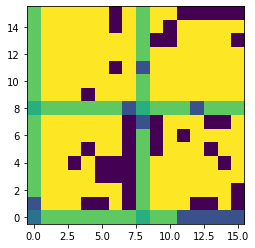

In [13]:
matplotlib.rcParams['animation.writer'] = 'ffmpeg'

data = generate_states_1_1(16, 0.4, 100, 1, 1, rerun=False, initial_spins=None)

anim = animate(data, 100, 0.1, save_fig=False, filename=None,
            show_fig=True)

rc('animation', html='html5')


HTML(anim.to_html5_video())

And now let us study the effects of the boundary. In the following video, N=10 and M=10, so there are 10 boundary configurations and 10 sublattice updates per boundary. I will use the previous configs as a source of boundary configs.

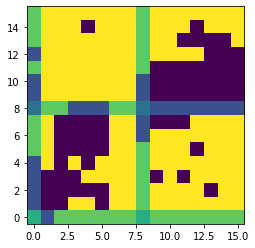

In [14]:
data = generate_states_splitting(16, 0.4, 10, 10, 1, (2, 2), 100, 1)

anim = animate(data.reshape((10, 10, 16, 16)), 100, 0.2, save_fig=False, filename=None,
            show_fig=True)
               
rc('animation', html='html5')

HTML(anim.to_html5_video())

Note that for simplicity, and for the model to appear smooth, I used step sizes of 1 in all cases. In reality, because of autocorrelations it is necessary to use a larger step size. I found in this project that 20 gave acceptable results - although this may degenerate around the critical point. Before moving on to the main classes in this code, there are a couple of utility functions that are necessary:

1. Chisq_pvalue : self explanatary
2. Naiive_weights : This is the weighting scheme generated by considering only whether one or both of the points in a twopt function are on the boundary

In [15]:
def chisq_pvalue(k, x):
  """
  INPUTS :
  --------
  k : int, the rank (number of degrees of freedom)
  x : float, the chi-sq value
  
  RETURNS :
  ---------
  chisq_pvalue : float, pvalue of chisq fit
  """
  return gammaincc(k / 2, x / 2)


def naiive_weights(L, splitting, delta, M):
  """
    INPUTS :
    --------
    L : int, sidelength of the lattice
    splitting : int, number of sublattices in the remaining dimension after slice-averaging
    delta : the displacement along the slice direction
    M : int, Number of sublattice updates per boundary update
    
    RETURNS :
    ---------
    (L, ) numpy array of float/int, whereby if a twopt function goes between two boundaries it has a weight of 1, 
        while if it's between a boundary and a subregion, or between two points in the same subregion, it is M,
        and if it's between two different subregions, it has a weight of M ** 2
  """
  # Get all the weights
  weights = numpy.ones(L) * M

  # Set boundaries to 1
  weights[::L // splitting] = 1

  # Roll this to get weights at second point
  yweights = numpy.roll(weights, -delta)

  # Calculate the regions
  regions = region_maker(L, (splitting, ))

  # roll this to get regions for second point
  yregions = numpy.roll(regions, -delta)

  # Use this to determine weights
  weights = numpy.where(regions != yregions, weights * yweights, weights)

  return weights[:L//splitting]

While the previous classes were related to the data-generation side of the algorithm, the following class is related to the interpretation of this data in order to produce two-point function values and a measure of their error. Both of them implement a "slice-coordinate" framework, where the lattice values for each configuration are averaged over all but one dimension. It can be shown that this approach preserves the two-point function form:

single_slice_ising:
    twopt(delta) : Function returning the twopt function depending on the distance between two points, delta.
    xi_cosh_fit(delta) :

In [16]:
class single_slice_ising:
  def __init__(self, L, beta, N, step, initial=1000, rerun_generation=False):
    """
        INPUTS :
        --------
        L : side length, int
        beta : inverse temperature, float
        N : Number of boundary configurations, int
        step : Number of update steps between configs, int
        initial : Number of initial configs that go unsaved, so that the system can reach equillibrium, int
        rerun_generation : Bool, if True then source files will be regenerated regardless of whether
            save files are found
    """
    # Generate or load in relevent configuration
    self.spins = generate_states_1_1(L, beta, N, step, initial, rerun=rerun_generation)

    # Average over one of the spatial dimensions of the lattice
    self.spin_slice = numpy.mean(self.spins, axis=2)
    self.beta = beta
    self.L = L
    self.N = N
    self.initial = initial
    self.step = step
    self.rerun_generation = rerun_generation
    self.twopt_values = {}

  def twopt(self, delta):
    """
      Function that calculates the value of the two-point with a spatial seperation of magnitude delta
      
      INPUTS :
      --------
      delta: seperation distance, int
      
      RETURNS :
      ---------
      twopt : (N, ) numpy array of floats, with each entry being the twopt value on a given configuration
    """
    # As algorithm is deterministic, then one can choose to load the results from a save file
    rerun = self.rerun_generation
    data_found = False
    directory = f"{base_directory}twopt/single_slice/"
    filename = f"""L{self.L}_beta{self.beta}_N{self.N}_step{self.step}_initial{self.initial}_delta{delta}.npy"""

    # Check if the data already exists (only if rerun_generation is False)
    data_found = True
    if not rerun:
      # Check if the file exists
      files = os.popen(f'ls {directory}')
      files = [x[:-1] for x in files]  # x[:-1] to remove the '\n' charachter
      if not filename in files:
        data_found = False

      else:
        twopt = numpy.load(f"{directory}{filename}")

    if (not data_found) or rerun:
      # Perform the two-point calculation
      twopt = self.spin_slice * numpy.roll(self.spin_slice, -delta, axis=1)

      if not os.path.isdir(directory):
        os.makedirs(directory)

      numpy.save(f"{directory}{filename}", twopt)

    self.twopt_values[delta] = twopt

    return twopt

    # Note: This still hasn't been averaged over the bootstrap samples, in case
    # the user is interested in extracting more statistics
    return result

  def xi_cosh_fit(self, no_samples, seed=False):
    if seed is False:
      seed = numpy.random.randint(0, 2 ** 32)

    result = numpy.zeros(no_samples)

    # Define the fitting function
    def f(params, x):
      A, xi = params[0], params[1]
      return A * (numpy.exp(-x / xi) + numpy.exp(-(self.L - x) / xi))

    # Initial guess for the fit
    guess = numpy.array([1, 1])

    # Define the bounds on the fitting parameters
    bounds = (numpy.array([0, 0]), numpy.array([1, numpy.inf]))

    # Collect all of the twopt correlators
    twopt_data = numpy.zeros((no_samples, self.L // 2 + 1, self.N))

    for i in range(1, self.L // 2 + 1):
      twopt_data[:, i, :] = self.twopt_connected(i, no_samples, seed=seed)

    p_values = numpy.zeros((no_samples, self.L // 2 - 3))
    xi_s = numpy.zeros((no_samples, self.L // 2 - 3))

    for i in tqdm(range(no_samples)):
      counter = 1

      for j in range(1, self.L // 2 - 1): # While the fit quality is not adequate
        # Calculate the covarience matrix (of the means hence the self.N - 1)
        cov = numpy.cov(twopt_data[i, j:, j:]) / (self.N - 1)

        # Decompose the matrix using Cholskey decomposition
        cov_1_2 = numpy.linalg.cholesky(cov)

        # Invert the covarience matrix sqrt
        cov_inv = numpy.linalg.inv(cov_1_2)
        
        # This should be close to the identity
        #numpy.dot(numpy.dot(cov_inv, cov), numpy.transpose(cov_inv))

        # Remove a short distance correlator where the fit isn't good enough.
        y_s = numpy.mean(twopt_data[i], axis=1)[j:]
        x_s = numpy.arange(j, self.L // 2 + 1)

        # Define the residuals function
        def residuals(params):
          unnormalized = y_s - f(params, x_s)
          return numpy.dot(cov_inv, unnormalized)
        
        res = least_squares(residuals, guess, bounds=bounds, xtol=False)
        
        # plt.errorbar(x_s, y_s, yerr=numpy.sqrt(numpy.diag(cov)), ls='', capsize=10)
        # plt.plot(x_s, f(res.x, x_s))

        n_dof = len(x_s) - len(res.x) # number of degrees of freedom
        p_values[i, j - 1] = chisq_pvalue(n_dof, numpy.sum(residuals(res.x) ** 2))
        xi_s[i, j - 1] = res.x[1]

    return p_values, xi_s

Let's have a look at an example. Below we consider a L=8 square lattice. We will consider the twopt correlator of points seperated by a distance of 5. The animation has 4 subplots:

1. The spin array
2. The slice variables, which are just 1. averaged in the vertical direction
3. The slice variables, shifted by delta
4. The twopt function, which is the product of the slice variables and the shifted slice variables. Technically this should then be averaged to get the actual value of the twopt function

In [17]:
def animate_twopt(single_slice, no_iterations, dt, delta, save_fig=False, filename=None,
            show_fig=True, plotting_dimensions=2, multilevel=False):
  """
    Function designed to show the twopt function working on slice coordinates
    
    INPUTS :
    --------
    single_slice : Object of type single_slice_ising

    no_iterations :
    type : int
    description : Number of times the flock is stepped

    save_fig=False :
    type : Bool
    description : If set to True then the animation will be saved in the
        directory the script is being run in
    
    filename=None :
    type : None or string
    description : A string that the file is saved under

    show_fig=True :
    type : Bool
    description : If True then the animation will display

    dt :
    type : float
    description : Change in time between frames

    delta :
    type : int
    description : twopt-function seperation

    multilevel :
    type : bool
    description : If true the algorithm uses multilevel spin data
  """
  lattice_data = single_slice.spins.astype(float)
  twopt = single_slice.twopt(delta)
  pdb.set_trace()

  # If the data is multilevel, we want to change the array shape to (N * M, L, L)
  # first
  L = lattice_data.shape[2]  # True for multilevel and single level
    
  if multilevel:
    N = lattice_data.shape[0]
    M = lattice_data.shape[1]
    lattice_data = lattice_data.reshape((N * M, L, L))
    slice_data = numpy.mean(lattice_data, axis=1)
    twopt = single_slice.twopt_raw(delta).reshape((N * M, L))

  if len(lattice_data.shape) == 4:
    lattice_data = lattice_data.reshape((lattice_data.shape[0] * lattice_data.shape[1], L, L))

  # Number of configs
  no_configs = lattice_data.shape[0]
  assert no_configs >= no_iterations, "Not enough configs to produce that many iterations"

  if save_fig:
    # Set up formatting for the movie files
    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=int(numpy.rint(1 / dt)), metadata=dict(artist='Me'), bitrate=400)

  # Create figure and axis
  fig, axes = plt.subplots(4, 1, gridspec_kw={'height_ratios': [5, 1, 1, 1]})

  # Setting the axes properties
  axes[0].set_xlim([-0.5, L - 0.5])
  axes[0].set_ylim([-0.5, L - 0.5])

  # Show the slice data
  x1 = numpy.mean(lattice_data[0], axis=1)
  ax1 = axes[1].bar(numpy.arange(len(x1)), x1)

  # Show the slice data at second point in two-point function
  x2 = numpy.roll(numpy.mean(lattice_data[0], axis=1), -delta)
  ax2 = axes[2].bar(numpy.arange(len(x1)), x2)

  # Show the product of the two points in the correlator
  ax3 = axes[3].bar(numpy.arange(len(x1)), twopt[0])

  # Plot appearance <---
  axes[1].set_aspect(0.85)
  axes[2].set_aspect(0.85)
  axes[3].set_aspect(0.85)

  for i in range(4):
    axes[i].set_xticklabels(["", ] * L)
    axes[i].set_xticks([])

  axes[0].set_yticks([])
  axes[0].set_yticklabels(["", ] * L)

  for i in range(1, 4):
    axes[i].set_ylim((-1, 1))

  axes[0].set_title("Spins")
  axes[1].set_title("Spin slice")
  axes[2].set_title("Spin slice, shifted by delta")
  axes[3].set_title("twopt function")

  fig.tight_layout(pad=1)
  # --->

  # For the purpose of highlighting the boundary layer (with splitting = 2)
  lattice_data[0, :, 0] = 0.5 * lattice_data[0, :, 0]
  lattice_data[0, :, L // 2] = 0.5 * lattice_data[0, :, L // 2]

  ax0 = axes[0].imshow(numpy.transpose(lattice_data[0]))

  axes = [ax0, ax1, ax2, ax3]

  def update(num):
#     print(f"Frame number: {num}/{no_iterations}")
    data0 = numpy.transpose(lattice_data[num])
    data1 = numpy.mean(data0, axis=0)
    data2 = numpy.roll(numpy.mean(data0, axis=0), -delta)
    data3 = twopt[num]
    data = [data0, data1, data2, data3]
    axs = [ax0, ax1, ax2, ax3]
    
    # Set new data into the image
    for i in range(1, 4):
      for bar, h in zip(axs[i], data[i]):
        bar.set_height(h)
        
    data0[:, 0] = 0.5 * data0[:, 0]
    data0[:, L // 2] = 0.5 * data0[:, L // 2]
    
    ax0.set_data(data0)

    return axes

  # Creating the Animation object
  ani = FuncAnimation(fig, update, frames=range(1, no_iterations),
          interval=int(dt * 1000), blit=False, repeat=False)
          
  if save_fig:
      ani.save(filename, writer=writer)

  if show_fig:
      plt.show()
  
  return ani

> <ipython-input-17-b1e8e3237a99>(45)animate_twopt()
-> L = lattice_data.shape[2]  # True for multilevel and single level
(Pdb) type(single_slice.twopt_raw(delta))
*** AttributeError: 'single_slice_ising' object has no attribute 'twopt_raw'
(Pdb) c


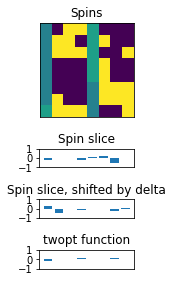

In [18]:
data = single_slice_ising(8, 0.2, 100, 1)

anim = animate_twopt(data, 100, 1, 5, save_fig=False, filename=None,
            show_fig=False)

rc('animation', html='html5')

HTML(anim.to_html5_video())

If we were to try and do something similar for a multilevel system the result would be like the following. The following class is quite large, so will be explained gradually as this document progresses.

In [46]:
class multi_slice_ising:
  def __init__(self, L, beta, N, M, splitting, Mstep=100, initial=1000, Nstep=1, source_file_step=100, rerun_generation=False):
    self.spins = generate_states_splitting(L, beta, N, M, Mstep, (splitting, 1), N * Nstep, initial, Nstep=Nstep, source_file_step=source_file_step, rerun=rerun_generation)

    self.spin_slice = numpy.mean(self.spins, axis=3)
    self.beta = beta
    self.L = L
    self.N = N
    self.initial = initial
    self.Mstep = Mstep
    self.Nstep = Nstep
    self.M = M
    self.Nstep = Nstep
    self.source_file_step = source_file_step
    self.rerun_generation = rerun_generation
    self.regions = region_maker(L, (splitting, ))
    self.twopt_values = {}
    self.splitting = splitting
    
    
  def twopt_raw(self, delta):
    """
      For educational purposes. Calculates the twopt function at each slice variable, on all (N, M) configs seperately
      returning an (N, M, L) shape array
    """
    rerun = self.rerun_generation   # Since there is no randomness
    data_found = False
    directory = f"{base_directory}twopt_raw/multi_slice/"
    filename = f"""L{self.L}_beta{self.beta}_N{self.N}_M{self.M}_source_step{self.source_file_step}_Nstep{self.Nstep}_Mstep{self.Mstep}_initial{self.initial}_delta{delta}_splitting{self.splitting}.npy"""

    # Check if the data already exists (only if rerun_generation is False)
    if not rerun:
      # Check if the file exists
      files = os.popen(f'ls {directory}')
      files = [x[:-1] for x in files]
      if not filename in files:
        data_found = False

      else:
        twopt_raw = numpy.load(f"{directory}{filename}")
        data_found = True

    if (not data_found) or rerun:
      x_slice = self.spin_slice
      y_slice = numpy.roll(x_slice, -delta, axis=2)
        
      twopt_raw = x_slice * y_slice
    
      if not os.path.isdir(directory):
        os.makedirs(directory)

      numpy.save(f"{directory}{filename}", twopt_raw)
    
    return twopt_raw
    
  def multilevelify_spins(self):
    """
      This function transforms the spin data of shape (N, M, L, L) to a multilevel dataset of data (N, M, M, L, L)
      where for each N, L, L, every combination along the M axis. Note that this is only appropriate to do when
      splitting=2 - hence the assert statement. For larger splittings, explicitly creating all permutations of
      sub-lattices is unnecessary.
    """
    assert self.splitting == 2
    
    pdb.set_trace()
    return numpy.einsum('ijkl, inkl->ijnkl', self.spins, self.spins)
    
     

  def twopt(self, delta, spin_slice=False):
    """
      delta is an integer
    """
    rerun = self.rerun_generation   # Since there is no randomness
    data_found = False
    directory = f"{base_directory}twopt/multi_slice/"
    filename = f"""L{self.L}_beta{self.beta}_N{self.N}_M{self.M}_source_step{self.source_file_step}_Nstep{self.Nstep}_Mstep{self.Mstep}_initial{self.initial}_delta{delta}_splitting{self.splitting}.npy"""

    # Check if the data already exists (only if rerun_generation is False)
    if not rerun:
      # Check if the file exists
      files = os.popen(f'ls {directory}')
      files = [x[:-1] for x in files]
      if not filename in files:
        data_found = False

      else:
        twopt = numpy.load(f"{directory}{filename}")
        data_found = True

    if spin_slice is not False:
      rerun = True

    if (not data_found) or rerun:
      # Calculate the twopt function for each value of N first
      if spin_slice is not False:
        x_slice = spin_slice
      else:
        x_slice = self.spin_slice

      y_slice = numpy.roll(x_slice, -delta, axis=2)

      regions = self.regions
      y_regions = numpy.roll(regions, -delta)

      combinatoric_av = numpy.zeros((self.N, self.L))
      # Multilevel product
      for i in tqdm(range(self.M)):
        for j in range(self.M):
          combinatoric_av += x_slice[:, i, :] * y_slice[:, j, :] / (self.M) ** 2
      
      # For twopt correlators where multilevel isn't valid
      within_region = x_slice * y_slice
      within_region_av = numpy.mean(within_region, axis=1)  # Average over sublattice axis

      twopt = numpy.where(regions != y_regions, combinatoric_av, within_region_av)

      if not os.path.isdir(directory):
        os.makedirs(directory)

      numpy.save(f"{directory}{filename}", twopt)

    self.twopt_values[delta] = twopt

    return twopt

  def twopt_best_estimate_connected_jackknife(self, delta, no_samples, seed=False, weights='weighted', rerun=False, penalty=0):
    """
      weights can take one of three key words : 'weighted' e.g. full multilevel method,
      'equal' e.g. 1, 1, 1, 1... for all sites and 'naiive' where the multilevel
      regions vs. boundaries are accounted for.
    """
    data_found = False
    directory = f"{base_directory}twopt_connected_jackknife/multi_slice/"

    # I may not use the penalty feature.
    if penalty == 0:
      filename = f"L{self.L}_beta{self.beta}_N{self.N}_M{self.M}_source_step{self.source_file_step}_Nstep{self.Nstep}_Mstep{self.Mstep}_initial{self.initial}_delta{delta}_no_samples{no_samples}_seed{seed}_weights{weights}.npy"

    else:
      filename = f"L{self.L}_beta{self.beta}_N{self.N}_M{self.M}_source_step{self.source_file_step}_Nstep{self.Nstep}_Mstep{self.Mstep}_initial{self.initial}_delta{delta}_no_samples{no_samples}_seed{seed}_weights{weights}_penalty{penalty}.npy"

    if not self.rerun_generation:
      data_found = True
      try:
        result = numpy.load(f"{directory}{filename}")
        
      except:
        data_found = False

    # Create the weight vectors:
    if weights is 'equal':
      weights_vector = numpy.ones(self.L // self.splitting)

    if weights is 'naiive':
      weights_vector = naiive_weights(self.L, self.splitting, delta, self.M)

    if (not data_found) or rerun:
      # Set the seed if given as an argument
      if seed:
        numpy.random.seed(seed)

      # Calculate bootstrap samples for each set
      bootstrap = numpy.random.randint(self.N, size=(no_samples, self.N))

      result = numpy.zeros(no_samples)

      for i in tqdm(range(no_samples)):
        # Randomly shuffle the configs
        spin_sample = self.spin_slice[bootstrap[i]]

        # Subtract the connected part
        spin_sample = spin_sample - numpy.mean(spin_sample)

        # Calculate the twopt function:
        twopt_sample = self.twopt_sample(delta, spin_slice=spin_sample)

        # Symmetrize over the subregions
        twopt_sample = twopt_sample.reshape(self.N, self.splitting, self.L // self.splitting)
        twopt_sample = numpy.mean(twopt_sample, axis=1)

        if weights is 'weighted':
          for j in range(self.N):
            # Select all but one config
            twopt_sample_rest = twopt_sample[numpy.arange(twopt_sample.shape[0]) != j]

            # Caclulate the covariance matrix
            cov_matrix = numpy.cov(twopt_sample_rest, rowvar=False)

            # Normalize the covariance matrix so that it has a determinant of 1
            cov_matrix = cov_matrix / (numpy.linalg.det(cov_matrix)) ** (1 / cov_matrix.shape[0])

            # Use these to obtain the optimal weights
            weights_ = get_weights(cov_matrix, penalty=penalty)

            # Use these weights to find the twopt function on the remaining config
            result[i] += numpy.average(twopt_sample[j], weights=weights_) / self.N
        
        else:
          result[i] = numpy.mean(numpy.average(twopt_sample, weights=weights))

      if not os.path.isdir(directory):
        os.makedirs(directory)

      numpy.save(f"{directory}{filename}", result)

    # Note: This still hasn't been averaged over the bootstrap samples, in case
    # the user is interested in extracting more statistics
    return result

  def twopt_best_estimate_jackknife(self, delta, no_samples, seed=False, weights=False, rerun=False, penalty=0, bin_size=1):
    data_found = False
    directory = f"{base_directory}twopt_jackknife/multi_slice/"

    if penalty == 0:
      filename = f"L{self.L}_beta{self.beta}_N{self.N}_M{self.M}_source_step{self.source_file_step}_Nstep{self.Nstep}_Mstep{self.Mstep}_initial{self.initial}_delta{delta}_no_samples{no_samples}_seed{seed}_weights{weights}_bin_size{bin_size}.npy"

    else:
      filename = f"L{self.L}_beta{self.beta}_N{self.N}_M{self.M}_source_step{self.source_file_step}_Nstep{self.Nstep}_Mstep{self.Mstep}_initial{self.initial}_delta{delta}_no_samples{no_samples}_seed{seed}_weights{weights}_bin_size{bin_size}_penalty{penalty}.npy"

    if not rerun:
      # Check if the file exists
      files = os.popen(f'ls {directory}')
      files = [x[:-1] for x in files]

      if not filename in files:
        data_found = False

      else:
        result = numpy.load(f"{directory}{filename}")
        data_found = True

    if (not data_found) or rerun:
      # Create the weight vectors:
      if weights is 'equal':
        weights_vector = numpy.ones(self.L // self.splitting)

      if weights is 'naiive':
        weights_vector = naiive_weights(self.L, self.splitting, delta, self.M)

      # Number of bins used for caclulation of the weights
      assert self.N % bin_size == 0
      no_bins = self.N // bin_size

      # Set the seed if given as an argument
      if seed:
        numpy.random.seed(seed)

      # Calculate bootstrap samples for each set
      bootstrap = numpy.random.randint(self.N, size=(no_samples, self.N))

      result = numpy.zeros(no_samples)

      # Load in the twopt calculations
      twopt = self.twopt(delta)

      # Symmetrize over the subregions
      twopt = twopt.reshape(self.N, self.splitting, self.L // self.splitting)
      twopt = numpy.mean(twopt, axis=1)

      for i in tqdm(range(no_samples)):
        # Randomly shuffle the configs
        twopt_sample = twopt[bootstrap[i]]

        if weights is False:
          for j in range(no_bins):
            # Select all but one bin
            twopt_sample_rest = twopt_sample[numpy.arange(twopt_sample.shape[0]) // bin_size != j]

            # And also extract this bin
            twopt_sample_bin = twopt_sample[numpy.arange(twopt_sample.shape[0]) // bin_size == j]

            # Caclulate the covariance matrices for each set
            cov_matrix = numpy.cov(twopt_sample_rest, rowvar=False)

            # Normalize the covariance matrix so that it has a determinant of 1
            cov_matrix = cov_matrix / (numpy.linalg.det(cov_matrix)) ** (1 / cov_matrix.shape[0])

            # Use these to obtain the optimal weights
            weights_vector = get_weights(cov_matrix, penalty=penalty)

            # Use the weights of one group to find the average of another
            result[i] += numpy.mean(numpy.average(twopt_sample_bin, weights=weights_vector, axis=1)) / no_bins
        
        else:
          result[i] = numpy.mean(numpy.average(twopt_sample, weights=weights_vector, axis=1))

      if not os.path.isdir(directory):
        os.makedirs(directory)

      numpy.save(f"{directory}{filename}", result)
    
    # Note: This still hasn't been averaged over the bootstrap samples, in case
    # the user is interested in extracting more statistics
    return result

  def twopt_chisq(self, delta, no_samples, seed=False, rerun=False):
    data_found = False
    directory = f"{base_directory}twopt_chisq/multi_slice/"

    filename = f"L{self.L}_beta{self.beta}_N{self.N}_M{self.M}_source_step{self.source_file_step}_Nstep{self.Nstep}_Mstep{self.Mstep}_initial{self.initial}_delta{delta}_no_samples{no_samples}_seed{seed}.npy"

    if not rerun:
      # Check if the file exists
      files = os.popen(f'ls {directory}')
      files = [x[:-1] for x in files]

      if not filename in files:
        data_found = False

      else:
        result = numpy.load(f"{directory}{filename}")
        data_found = True
    
    if (not data_found) or rerun:
      result = numpy.zeros(no_samples)

      # Set the seed if given as an argument
      if seed:
        numpy.random.seed(seed)

      # Calculate bootstrap samples for each set
      bootstrap = numpy.random.randint(self.N, size=(no_samples, self.N))

      # Load in the twopt calculations
      twopt = self.twopt(delta)

      # Symmetrize over the subregions
      twopt = twopt.reshape(self.N, self.splitting, self.L // self.splitting)
      twopt = numpy.mean(twopt, axis=1)
 
      for i in tqdm(range(no_samples)):
        # Randomly shuffle the configs
        twopt_sample = twopt[bootstrap[i]]

        # Look at the chisq minimization method
        cov_matrix = numpy.cov(twopt_sample, rowvar=False)
        cov_matrix = cov_matrix / (numpy.linalg.det(cov_matrix)) ** (1 / cov_matrix.shape[0])
        cov_inv = numpy.linalg.inv(cov_matrix)
        y_s = numpy.mean(twopt_sample, axis=0)
        x_s = numpy.arange(0, twopt_sample.shape[1])

        def chisq(mu):
          resid = y_s - mu
          return numpy.dot(resid, numpy.dot(cov_inv, resid))
        
        res = minimize_scalar(chisq, bounds=[-1, 1], method='bounded')

        mu = res.x

        result[i] = mu

      if not os.path.isdir(directory):
        os.makedirs(directory)

      numpy.save(f"{directory}{filename}", result)

    return result
   
  def twopt_best_estimate_connected(self, delta, no_samples, seed=False, rerun=False, weights=False, penalty=0):
    data_found = False
    directory = f"{base_directory}twopt_connected/multi_slice/"
    if penalty == 0:
      filename = f"""L{self.L}_beta{self.beta}_N{self.N}_M{self.M}_source_step{self.source_file_step}_Nstep{self.Nstep}_Mstep{self.Mstep}_initial{self.initial}_delta{delta}_no_samples{no_samples}_seed{seed}_weights{weights}.npy"""
    else:
      filename = f"""L{self.L}_beta{self.beta}_N{self.N}_M{self.M}_source_step{self.source_file_step}_Nstep{self.Nstep}_Mstep{self.Mstep}_initial{self.initial}_delta{delta}_no_samples{no_samples}_seed{seed}_weights{weights}_penalty{penalty}.npy"""
      
    # Check if the data already exists (only if rerun_generation is False)
    if not self.rerun_generation:
      data_found = True
      try:
        result = numpy.load(f"{directory}{filename}")
        
      except:
        data_found = False

    # Create the weight vectors:
    if weights is 'equal':
      weights_vector = numpy.ones(self.L // self.splitting)

    if weights is 'naiive':
      weights_vector = naiive_weights(self.L, self.splitting, delta, self.M)

    if (not data_found) or rerun:
      # Set the seed if given as an argument
      if seed:
        numpy.random.seed(seed)

      # Calculate bootstrap samples for each set
      bootstrap = numpy.random.randint(self.N, size=(no_samples, self.N))

      result1 = numpy.zeros(no_samples)
      result2 = numpy.zeros(no_samples)

      for i in tqdm(range(no_samples)):
        # Extract the spins being used here
        spin_slice = self.spin_slice[bootstrap[i]]

        # Split into two groups
        spin_slice1 = spin_slice[:self.N // 2]
        spin_slice2 = spin_slice[self.N // 2:]

        # Subtract the onept function - seperately for each half
        spin_slice1 = spin_slice1 - numpy.mean(spin_slice1)
        spin_slice2 = spin_slice2 - numpy.mean(spin_slice2)

        # Calculate the connected twopt function
        twopt1 = self.twopt(delta, spin_slice=spin_slice1)
        twopt2 = self.twopt(delta, spin_slice=spin_slice2)

        # Symmetrize over the subregions
        twopt1 = twopt1.reshape(self.N // 2, self.splitting, self.L // self.splitting)
        set1 = numpy.mean(twopt1, axis=1)
        
        twopt2 = twopt2.reshape(self.N // 2, self.splitting, self.L // self.splitting)
        set2 = numpy.mean(twopt2, axis=1)

        if weights is 'weighted':
          # Caclulate the covariance matrices for each set
          cov_matrix1 = numpy.cov(set1, rowvar=False)
          cov_matrix2 = numpy.cov(set2, rowvar=False)

          # Normalize the covariance matrix so that it has a determinant of 1
          cov_matrix1 = cov_matrix1 / (numpy.linalg.det(cov_matrix1)) ** (1 / cov_matrix1.shape[0])
          cov_matrix2 = cov_matrix2 / (numpy.linalg.det(cov_matrix2)) ** (1 / cov_matrix2.shape[0])

          # Use these to obtain the optimal weights
          weights1 = get_weights(cov_matrix1, penalty=penalty)
          weights2 = get_weights(cov_matrix2, penalty=penalty)

          # Use the weights of one group to find the average of another
          result2[i] = numpy.mean(numpy.average(set2, axis=1, weights=weights1))
          result1[i] = numpy.mean(numpy.average(set1, axis=1, weights=weights2))

        else:
          result2[i] = numpy.mean(numpy.average(set2, axis=1, weights=weights_vector))
          result1[i] = numpy.mean(numpy.average(set1, axis=1, weights=weights_vector))

      result = (result1 + result2) / 2

      if not os.path.isdir(directory):
        os.makedirs(directory)

      numpy.save(f"{directory}{filename}", result)

    result = numpy.load(f"{directory}{filename}")

    # Note: This still hasn't been averaged over the bootstrap samples, in case
    # the user is interested in extracting more statistics
    return result


> <ipython-input-17-b1e8e3237a99>(45)animate_twopt()
-> L = lattice_data.shape[2]  # True for multilevel and single level
(Pdb) type(single_slice.twopt_raw(delta))
<class 'numpy.ndarray'>
(Pdb) c


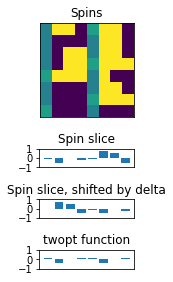

In [20]:
data = multi_slice_ising(8, 0.2, 10, 10, 2)

anim = animate_twopt(data, 100, 1, 4, save_fig=False, filename=None,
            show_fig=False, multilevel=True)

rc('animation', html='html5')

HTML(anim.to_html5_video())

One thing that you may notice in the video above is that the contribution to the twopt function between the boundarys doesn't change within a given boundary configuration. For this reason this contribution to the twopt function is under sampled compared to other contributions, and so has a higer standard deviation than other contributions. Keep this thought in mind as we continue. The next demonstration is designed to reveal the multilevel aspect of the code. This multilevel aspect involves taking all possible combinations of the sublattices for an individual boundary config.

SINGLEVEL


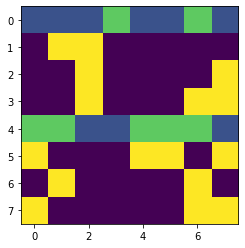

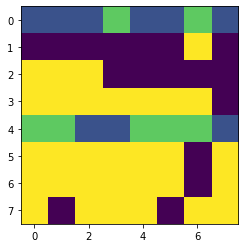

MULTILEVEL


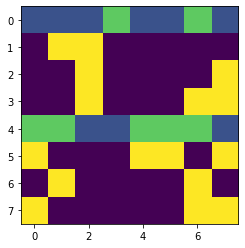

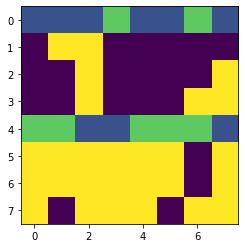

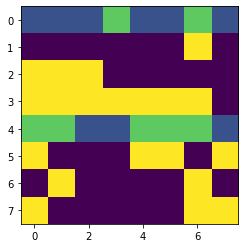

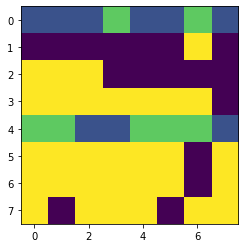

In [21]:
N = 1
M = 2
L = 8
data = multi_slice_ising(L, 0.2, N, M, 2)

spins = data.spins.astype(float)

multilevel_spins = numpy.zeros((N, M, M, L, L))

for i in range(N):
    for j1 in range(M):
        for j2 in range(M):
            # Multilevel spins have all combinations of sublattices
            multilevel_spins[i, j1, j2, :L//2, :] = spins[i, j1, :L//2, :]
            multilevel_spins[i, j1, j2, L//2:, :] = spins[i, j2, L//2:, :]

spins[..., 0, :] = 0.5 * spins[..., 0, :] # To highlight the boundary layer
spins[..., L // 2, :] = 0.5 * spins[..., L // 2, :] # To highlight the boundary layer

print("SINGLEVEL")
for i in range(N):
    for j in range(M):
        plt.imshow(spins[i, j])
        plt.show()
        
print("MULTILEVEL")

# After making multilevel states
multilevel_spins[..., 0, :] = multilevel_spins[..., 0, :] * 0.5 # To highlight the boundary layer
multilevel_spins[..., L//2, :] = multilevel_spins[..., L//2, :] * 0.5 # To highlight the boundary layer
for i in range(N):
    for j1 in range(M):
        for j2 in range(M):
            plt.imshow(multilevel_spins[i, j1, j2])
            plt.show()

This really is the magic of multilevel. We've gone from 2 to 2^2 configurations, almost for free. However, all is not what it seems on the surface. If the correlation length is very large, then each configuration will be largely determined by the boundary and so won't be fully independent.

While all estimators of the two-point function have the same mean, they have varying variance and covariance relative to eachother. To quickly define what we mean here, we first average the two-point function over the M^2 subconfigurations produced by multilevel, to get N values for each slice coordinate (N x L overall). We can then consider the L x L empirical covariance matrix of this data.

No source configuration files - generating these first
Generating states for : L = 8, N = 50, beta = 0.2000000000, splitting = (1, 1)


 35%|███▍      | 315/901 [00:00<00:00, 3145.44it/s]

Generating states for : L = 8, N = 50, M = 10, beta = 0.2000000000, splitting = (2, 1)



 28%|██▊       | 251/901 [00:00<00:00, 2508.02it/s]


100%|██████████| 10/10 [00:00<00:00, 2496.76it/s]


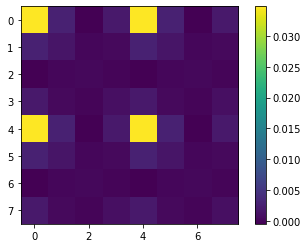

In [51]:
N = 50
M = 10
L = 8

numpy.random.seed(23432)

data = multi_slice_ising(L, 0.2, N, M, 2, rerun_generation=True)

twopt_data = data.twopt(L // 2)

plt.imshow(numpy.cov(twopt_data, rowvar=False))
plt.colorbar()

Let's interpret the above. Firstly, let's note that delta is L//2, so half the lattice size, so there is a correlator between the two boundaries. This twopt function is the same accross all M^2 sublattices for each boundary, and so is undersampled. This leads to it having a high variance as it's relatively undersampled. The boundaries are located at positions 0 and 4, and so (0,0) in the above is the variance of the first boundary correlator to the second. Similarly with (4, 4).

We see that the covariance is also significant. What is prehaps suprising is that the variance and covariance of points closer to the boundary are higher. This is because these points are influenced by the boundary and therefore vary less than they should.

One thing to note is that the algorithm is symmetric in exchange of the 2 sublattices. We can simplify the covariance using this fact by averaging over the subregions. Neat huh?

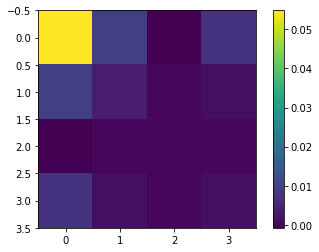

In [48]:
twopt_data = ((twopt_data + numpy.roll(twopt_data, -L//2, axis=1))/2)[:, :L//2]

plt.imshow(numpy.cov(twopt_data, rowvar=False))
plt.colorbar()

Okay great, we can find the covariance matrix - how is this useful exactly?

To see how, we will need some maths. A priori, all of the two-point estimators at each slice coordinate are random variables with a mean given by the true value of the twopt function and some covariance matrix, COV. By averaging over the N boundary configurations and assuming that the central limit theorum holds, then the two-point estimators are of the form $N\left(\mu_{phys}, \frac{\sigma^2}{N}\right)$. When we make a weighted average of these estimators, with weight vector $\textbf{w}$, we get a general result of $N\left(\mu_{phys}, \frac{\textbf{w}\cdot COV \cdot \textbf{w}}{N}\right)$.

We therefore get the minimization problem of minimizing $\textbf{w}\cdot COV \cdot \textbf{w}$ with respect to $\textbf{w}$, while maintaining $\sum_x{w(x)} = 1$. This is exactly what the following function does, through the method of Lagrange multipliers

In [49]:
def get_weights(cov_matrix):
  L = cov_matrix.shape[0]

  A = numpy.zeros((L + 1, L + 1))

  A[:-1, :-1] = cov_matrix
  A[:-1, -1] = 1
  A[-1, :-1] = 1
  A[-1, -1] = 0
  b = numpy.zeros(L + 1)
  b[-1] = 1

  # pdb.set_trace()

  Y = numpy.linalg.solve(A, b)

  weights = Y[:-1]

  # Check weights are close to one
  assert numpy.abs(numpy.sum(weights) - 1) < 10 ** -9

  return weights

In [50]:
get_weights(numpy.cov(twopt_data, rowvar=False))

array([-0.02731318, -0.09250436,  0.70504787,  0.41476967])

Unsuprisingly the method weights the boundary unfavorably (the negative value is a symptom of overfitting - the point is that the value is close to zero). In contrast the site furthest from the boundary gets the highest weight of 0.6